# Assignment 2: Optimal Policies with Dynamic Programming

Welcome to Assignment 2. This notebook will help you understand:
- Policy Evaluation and Policy Improvement.
- Value and Policy Iteration.
- Bellman Equations.

## Gridworld City

Gridworld City, a thriving metropolis with a booming technology industry, has recently experienced an influx of grid-loving software engineers. Unfortunately, the city's street parking system, which charges a fixed rate, is struggling to keep up with the increased demand. To address this, the city council has decided to modify the pricing scheme to better promote social welfare. In general, the city considers social welfare higher when more parking is being used, the exception being that the city prefers that at least one spot is left unoccupied (so that it is available in case someone really needs it). The city council has created a Markov decision process (MDP) to model the demand for parking with a reward function that reflects its preferences. Now the city has hired you &mdash; an expert in dynamic programming &mdash; to help determine an optimal policy.

## Preliminaries
You'll need two imports to complete this assigment:
- numpy: The fundamental package for scientific computing with Python.
- tools: A module containing an environment and a plotting function.

There are also some other lines in the cell below that are used for grading and plotting &mdash; you needn't worry about them.

In this notebook, all cells are locked except those that you are explicitly asked to modify. It is up to you to decide how to implement your solution in these cells, **but please do not import other libraries** &mdash; doing so will break the autograder.

In [1]:
%%capture
%matplotlib inline
import numpy as np
import pickle
import tools

In the city council's parking MDP, states are nonnegative integers indicating how many parking spaces are occupied, actions are nonnegative integers designating the price of street parking, the reward is a real value describing the city's preference for the situation, and time is discretized by hour. As might be expected, charging a high price is likely to decrease occupancy over the hour, while charging a low price is likely to increase it.

For now, let's consider an environment with three parking spaces and three price points. Note that an environment with three parking spaces actually has four states &mdash; zero, one, two, or three spaces could be occupied.

In [2]:
num_spaces = 3
num_prices = 3
env = tools.ParkingWorld(num_spaces, num_prices)
V = np.zeros(num_spaces + 1)
pi = np.ones((num_spaces + 1, num_prices)) / num_prices

The value function is a one-dimensional array where the $i$-th entry gives the value of $i$ spaces being occupied.

In [3]:
V

array([0., 0., 0., 0.])

In [4]:
state = 0
V[state]

0.0

In [5]:
state = 0
value = 10
V[state] = value
V

array([10.,  0.,  0.,  0.])

In [6]:
for s, v in enumerate(V):
    print(f'State {s} has value {v}')

State 0 has value 10.0
State 1 has value 0.0
State 2 has value 0.0
State 3 has value 0.0


The policy is a two-dimensional array where the $(i, j)$-th entry gives the probability of taking action $j$ in state $i$.

In [7]:
pi

array([[0.33333333, 0.33333333, 0.33333333],
       [0.33333333, 0.33333333, 0.33333333],
       [0.33333333, 0.33333333, 0.33333333],
       [0.33333333, 0.33333333, 0.33333333]])

In [8]:
state = 0
pi[state]

array([0.33333333, 0.33333333, 0.33333333])

In [9]:
state = 0
action = 1
pi[state, action]

0.3333333333333333

In [10]:
pi[state] = np.array([0.75, 0.21, 0.04])
pi

array([[0.75      , 0.21      , 0.04      ],
       [0.33333333, 0.33333333, 0.33333333],
       [0.33333333, 0.33333333, 0.33333333],
       [0.33333333, 0.33333333, 0.33333333]])

In [11]:
for s, pi_s in enumerate(pi):
    print(f''.join(f'pi(A={a}|S={s}) = {p.round(2)}' + 4 * ' ' for a, p in enumerate(pi_s)))

pi(A=0|S=0) = 0.75    pi(A=1|S=0) = 0.21    pi(A=2|S=0) = 0.04    
pi(A=0|S=1) = 0.33    pi(A=1|S=1) = 0.33    pi(A=2|S=1) = 0.33    
pi(A=0|S=2) = 0.33    pi(A=1|S=2) = 0.33    pi(A=2|S=2) = 0.33    
pi(A=0|S=3) = 0.33    pi(A=1|S=3) = 0.33    pi(A=2|S=3) = 0.33    


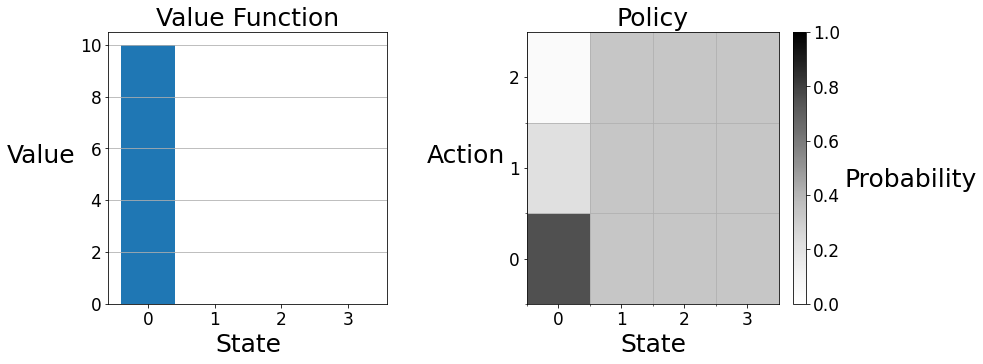

In [12]:
tools.plot(V, pi)

We can visualize a value function and policy with the `plot` function in the `tools` module. On the left, the value function is displayed as a barplot. State zero has an expected return of ten, while the other states have an expected return of zero. On the right, the policy is displayed on a two-dimensional grid. Each vertical strip gives the policy at the labeled state. In state zero, action zero is the darkest because the agent's policy makes this choice with the highest probability. In the other states the agent has the equiprobable policy, so the vertical strips are colored uniformly.

You can access the state space and the action set as attributes of the environment.

In [13]:
env.S

[0, 1, 2, 3]

In [14]:
env.A

[0, 1, 2]

You will need to use the environment's `transitions` method to complete this assignment. The method takes a state and an action and returns a 2-dimensional array, where the entry at $(i, 0)$ is the reward for transitioning to state $i$ from the current state and the entry at $(i, 1)$ is the conditional probability of transitioning to state $i$ given the current state and action.

In [15]:
state = 3
action = 1
transitions = env.transitions(state, action)
transitions

array([[1.        , 0.12390437],
       [2.        , 0.15133714],
       [3.        , 0.1848436 ],
       [2.        , 0.53991488]])

In [16]:
for s_, (r, p) in enumerate(transitions):
    print(f'p(S\'={s_}, R={r} | S={state}, A={action}) = {p.round(2)}')

p(S'=0, R=1.0 | S=3, A=1) = 0.12
p(S'=1, R=2.0 | S=3, A=1) = 0.15
p(S'=2, R=3.0 | S=3, A=1) = 0.18
p(S'=3, R=2.0 | S=3, A=1) = 0.54


## Section 1: Policy Evaluation

You're now ready to begin the assignment! First, the city council would like you to evaluate the quality of the existing pricing scheme. Policy evaluation works by iteratively applying the Bellman equation for $v_{\pi}$ to a working value function, as an update rule, as shown below.

$$\large v(s) \leftarrow \sum_a \pi(a | s) \sum_{s', r} p(s', r | s, a)[r + \gamma v(s')]$$
This update can either occur "in-place" (i.e. the update rule is sequentially applied to each state) or with "two-arrays" (i.e. the update rule is simultaneously applied to each state). Both versions converge to $v_{\pi}$ but the in-place version usually converges faster. **In this assignment, we will be implementing all update rules in-place**, as is done in the pseudocode of chapter 4 of the textbook. 

We have written an outline of the policy evaluation algorithm described in chapter 4.1 of the textbook. It is left to you to fill in the `bellman_update` function to complete the algorithm.

In [17]:
def evaluate_policy(env, V, pi, gamma, theta):
    while True:
        delta = 0
        for s in env.S:
            v = V[s]
            bellman_update(env, V, pi, s, gamma)
            delta = max(delta, abs(v - V[s]))
        if delta < theta:
            break
    return V

In [18]:
# [Graded]
def bellman_update(env, V, pi, s, gamma):
    """Mutate ``V`` according to the Bellman update equation."""
    ### START CODE HERE ###
    v = 0
    for action, (prob_action) in enumerate(pi[s]):
        transitions = env.transitions(s, action)
        for next_state, (reward, prob_next_state) in enumerate(transitions):
             v += prob_action * (prob_next_state * (reward + gamma*V[next_state]))
    V[s] = v
    ### END CODE HERE ###

The cell below uses the policy evaluation algorithm to evaluate the city's policy, which charges a constant price of one.

In [19]:
%reset_selective -f "^num_spaces$|^num_prices$|^env$|^V$|^pi$|^gamma$|^theta$"
num_spaces = 10
num_prices = 4
env = tools.ParkingWorld(num_spaces, num_prices)
V = np.zeros(num_spaces + 1)
city_policy = np.zeros((num_spaces + 1, num_prices))
city_policy[:, 1] = 1
gamma = 0.9
theta = 0.1
V = evaluate_policy(env, V, city_policy, gamma, theta)

You can use the ``plot`` function to visualize the final value function and policy.

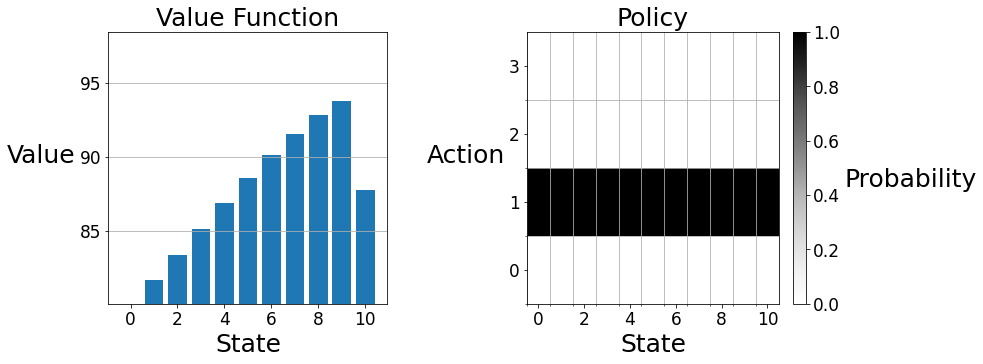

In [20]:
tools.plot(V, city_policy)

You can check the output (rounded to one decimal place) against the answer below:<br>
State $\quad\quad$    Value<br>
0 $\quad\quad\quad\;$        80.0<br>
1 $\quad\quad\quad\;$        81.7<br>
2 $\quad\quad\quad\;$        83.4<br>
3 $\quad\quad\quad\;$        85.1<br>
4 $\quad\quad\quad\;$        86.9<br>
5 $\quad\quad\quad\;$        88.6<br>
6 $\quad\quad\quad\;$        90.1<br>
7 $\quad\quad\quad\;$        91.6<br>
8 $\quad\quad\quad\;$        92.8<br>
9 $\quad\quad\quad\;$        93.8<br>
10 $\quad\quad\;\;\,\,$       87.8<br>

Observe that the value function qualitatively resembles the city council's preferences &mdash; it monotonically increases as more parking is used, until there is no parking left, in which case the value is lower. Because of the relatively simple reward function (more reward is accrued when many but not all parking spots are taken and less reward is accrued when few or all parking spots are taken) and the highly stochastic dynamics function (each state has positive probability of being reached each time step) the value functions of most policies will qualitatively resemble this graph. However, depending on the intelligence of the policy, the scale of the graph will differ. In other words, better policies will increase the expected return at every state rather than changing the relative desirability of the states. Intuitively, the value of a less desirable state can be increased by making it less likely to remain in a less desirable state. Similarly, the value of a more desirable state can be increased by making it more likely to remain in a more desirable state. That is to say, good policies are policies that spend more time in desirable states and less time in undesirable states. As we will see in this assignment, such a steady state distribution is achieved by setting the price to be low in low occupancy states (so that the occupancy will increase) and setting the price high when occupancy is high (so that full occupancy will be avoided).

The cell below will check that your code passes the test case above. (Your code passed if the cell runs without error.) Your solution will also be checked against hidden test cases for your final grade. (So don't hard code parameters into your solution.)

In [21]:
## Test Code for bellman_update() ## 
with open('section1', 'rb') as handle:
    V_correct = pickle.load(handle)
np.testing.assert_array_almost_equal(V, V_correct)

## Section 2: Policy Iteration
Now the city council would like you to compute a more efficient policy using policy iteration. Policy iteration works by alternating between evaluating the existing policy and making the policy greedy with respect to the existing value function. We have written an outline of the policy iteration algorithm described in chapter 4.3 of the textbook. We will make use of the policy evaluation algorithm you completed in section 1. It is left to you to fill in the `q_greedify_policy` function, such that it modifies the policy at $s$ to be greedy with respect to the q-values at $s$, to complete the policy improvement algorithm.

In [23]:
def improve_policy(env, V, pi, gamma):
    policy_stable = True
    for s in env.S:
        old = pi[s].copy()
        q_greedify_policy(env, V, pi, s, gamma)
        if not np.array_equal(pi[s], old):
            policy_stable = False
    return pi, policy_stable

def policy_iteration(env, gamma, theta):
    V = np.zeros(len(env.S))
    pi = np.ones((len(env.S), len(env.A))) / len(env.A)
    policy_stable = False
    while not policy_stable:
        V = evaluate_policy(env, V, pi, gamma, theta)
        pi, policy_stable = improve_policy(env, V, pi, gamma)
    return V, pi

In [24]:
# [Graded]
def q_greedify_policy(env, V, pi, s, gamma):
    """Mutate ``pi`` to be greedy with respect to the q-values induced by ``V``."""
    ### START CODE HERE ###
    Q_A = np.zeros_like(pi[s]) # CREATE ARRAY TO STORE Q-VALUES 
    for action, (prob_action) in enumerate(pi[s]):
        transitions = env.transitions(s, action)
        for next_state, (reward, prob_next_state) in enumerate(transitions):
            Q_A[action] += prob_action * (prob_next_state * (reward + gamma*V[next_state]))
    
    argmax = np.argmax(Q_A)
    pi[s] = np.zeros_like(pi[s])
    pi[s, argmax] = 1
    ### END CODE HERE ###

When you are ready to test the policy iteration algorithm, run the cell below.

In [25]:
%reset_selective -f "^num_spaces$|^num_prices$|^env$|^V$|^pi$|^gamma$|^theta$"
env = tools.ParkingWorld(num_spaces=10, num_prices=4)
gamma = 0.9
theta = 0.1
V, pi = policy_iteration(env, gamma, theta)

You can use the ``plot`` function to visualize the final value function and policy.

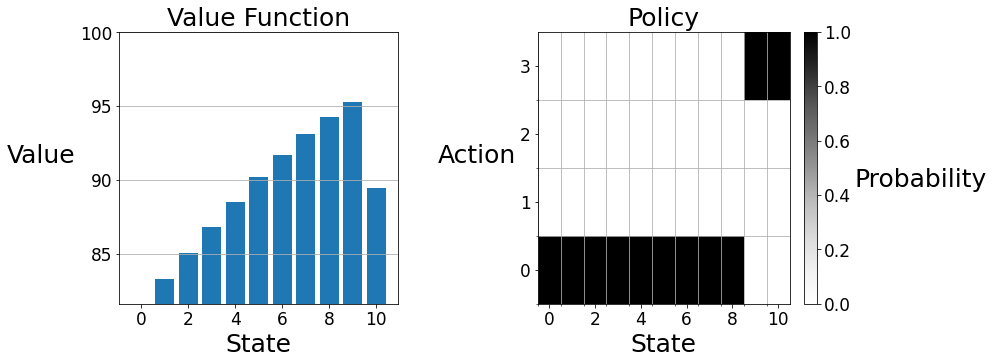

In [26]:
tools.plot(V, pi)

You can check the value function (rounded to one decimal place) and policy against the answer below:<br>
State $\quad\quad$    Value $\quad\quad$ Action<br>
0 $\quad\quad\quad\;$        81.6 $\quad\quad\;$ 0<br>
1 $\quad\quad\quad\;$        83.3 $\quad\quad\;$ 0<br>
2 $\quad\quad\quad\;$        85.0 $\quad\quad\;$ 0<br>
3 $\quad\quad\quad\;$        86.8 $\quad\quad\;$ 0<br>
4 $\quad\quad\quad\;$        88.5 $\quad\quad\;$ 0<br>
5 $\quad\quad\quad\;$        90.2 $\quad\quad\;$ 0<br>
6 $\quad\quad\quad\;$        91.7 $\quad\quad\;$ 0<br>
7 $\quad\quad\quad\;$        93.1 $\quad\quad\;$ 0<br>
8 $\quad\quad\quad\;$        94.3 $\quad\quad\;$ 0<br>
9 $\quad\quad\quad\;$        95.3 $\quad\quad\;$ 3<br>
10 $\quad\quad\;\;\,\,$      89.5 $\quad\quad\;$ 3<br>

The cell below will check that your code passes the test case above. (Your code passed if the cell runs without error.) Your solution will also be checked against hidden test cases for your final grade. (So don't hard code parameters into your solution.)

In [27]:
## Test Code for q_greedify_policy() ##
with open('section2', 'rb') as handle:
    V_correct, pi_correct = pickle.load(handle)
np.testing.assert_array_almost_equal(V, V_correct)
np.testing.assert_array_almost_equal(pi, pi_correct)

## Section 3: Value Iteration
The city has also heard about value iteration and would like you to implement it. Value iteration works by iteratively applying the Bellman optimality equation for $v_{\ast}$ to a working value function, as an update rule, as shown below.

$$\large v(s) \leftarrow \max_a \sum_{s', r} p(s', r | s, a)[r + \gamma v(s')]$$
We have written an outline of the value iteration algorithm described in chapter 4.4 of the textbook. It is left to you to fill in the `bellman_optimality_update` function to complete the value iteration algorithm.

In [28]:
def value_iteration(env, gamma, theta):
    V = np.zeros(len(env.S))
    while True:
        delta = 0
        for s in env.S:
            v = V[s]
            bellman_optimality_update(env, V, s, gamma)
            delta = max(delta, abs(v - V[s]))
        if delta < theta:
            break
    pi = np.ones((len(env.S), len(env.A))) / len(env.A)
    for s in env.S:
        q_greedify_policy(env, V, pi, s, gamma)
    return V, pi

In [29]:
# [Graded]
def bellman_optimality_update(env, V, s, gamma):
    """Mutate ``V`` according to the Bellman optimality update equation."""
    ### START CODE HERE ###
    Q_A = np.zeros(len(env.A))
    for action in env.A:
        transitions = env.transitions(s, action)
        for next_state, (reward, prob_next_state) in enumerate(transitions):
            Q_A[action] += prob_next_state * (reward + gamma*V[next_state])
    V[s] = np.amax(Q_A)
    ### END CODE HERE ###

When you are ready to test the value iteration algorithm, run the cell below.

In [30]:
%reset_selective -f "^num_spaces$|^num_prices$|^env$|^V$|^pi$|^gamma$|^theta$"
env = tools.ParkingWorld(num_spaces=10, num_prices=4)
gamma = 0.9
theta = 0.1
V, pi = value_iteration(env, gamma, theta)

You can use the ``plot`` function to visualize the final value function and policy.

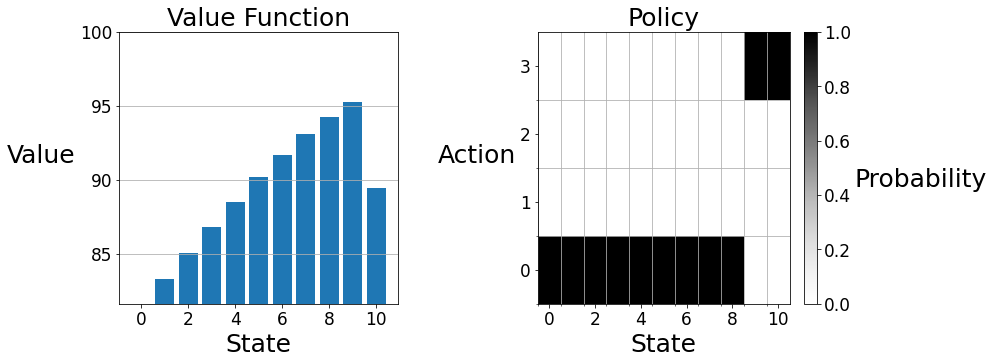

In [31]:
tools.plot(V, pi)

You can check your value function (rounded to one decimal place) and policy against the answer below:<br>
State $\quad\quad$    Value $\quad\quad$ Action<br>
0 $\quad\quad\quad\;$        81.6 $\quad\quad\;$ 0<br>
1 $\quad\quad\quad\;$        83.3 $\quad\quad\;$ 0<br>
2 $\quad\quad\quad\;$        85.0 $\quad\quad\;$ 0<br>
3 $\quad\quad\quad\;$        86.8 $\quad\quad\;$ 0<br>
4 $\quad\quad\quad\;$        88.5 $\quad\quad\;$ 0<br>
5 $\quad\quad\quad\;$        90.2 $\quad\quad\;$ 0<br>
6 $\quad\quad\quad\;$        91.7 $\quad\quad\;$ 0<br>
7 $\quad\quad\quad\;$        93.1 $\quad\quad\;$ 0<br>
8 $\quad\quad\quad\;$        94.3 $\quad\quad\;$ 0<br>
9 $\quad\quad\quad\;$        95.3 $\quad\quad\;$ 3<br>
10 $\quad\quad\;\;\,\,$      89.5 $\quad\quad\;$ 3<br>

The cell below will check that your code passes the test case above. (Your code passed if the cell runs without error.) Your solution will also be checked against hidden test cases for your final grade. (So don't hard code parameters into your solution.)

In [32]:
## Test Code for bellman_optimality_update() ## 
with open('section3', 'rb') as handle:
    V_correct, pi_correct = pickle.load(handle)
np.testing.assert_array_almost_equal(V, V_correct)
np.testing.assert_array_almost_equal(pi, pi_correct)

In the value iteration algorithm above, a policy is not explicitly maintained until the value function has converged. Below, we have written an identically behaving value iteration algorithm that maintains an updated policy. Writing value iteration in this form makes its relationship to policy iteration more evident. Policy iteration alternates between doing complete greedifications and complete evaluations. On the other hand, value iteration alternates between doing local greedifications and local evaluations. 

In [33]:
def value_iteration2(env, gamma, theta):
    V = np.zeros(len(env.S))
    pi = np.ones((len(env.S), len(env.A))) / len(env.A)
    while True:
        delta = 0
        for s in env.S:
            v = V[s]
            q_greedify_policy(env, V, pi, s, gamma)
            bellman_update(env, V, pi, s, gamma)
            delta = max(delta, abs(v - V[s]))
        if delta < theta:
            break
    return V, pi

You can try the second value iteration algorithm by running the cell below.

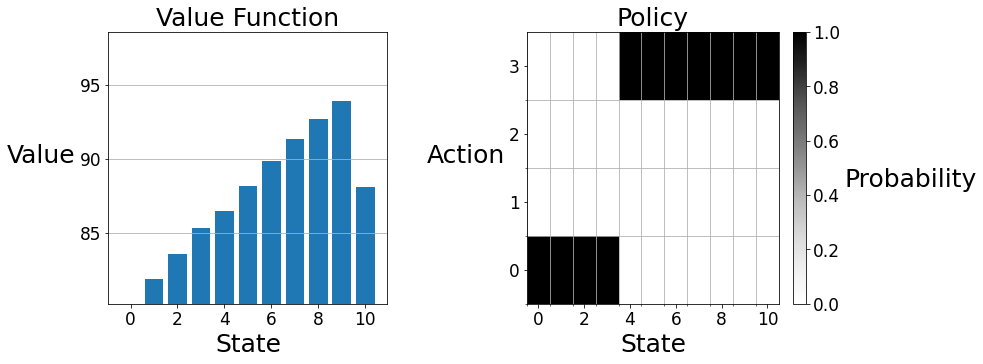

In [34]:
%reset_selective -f "^num_spaces$|^num_prices$|^env$|^V$|^pi$|^gamma$|^theta$"
env = tools.ParkingWorld(num_spaces=10, num_prices=4)
gamma = 0.9
theta = 0.1
V, pi = value_iteration2(env, gamma, theta)
tools.plot(V, pi)

## Wrapping Up
Congratulations, you've completed assignment 2! In this assignment, we investigated policy evaluation and policy improvement, policy iteration and value iteration, and Bellman updates. Gridworld City thanks you for your service!